In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Plotting toggle
plot = False

# Base directory
base_dir = 'D:\\STUDIA\\Projekt Grupowy\\actual-lbls\\analyzer\\'

# Read the CSV file
df = pd.read_csv(base_dir + 'label_with_file_path.csv')

def data_without_extreme_spikes(data, segment_size):
    ranges = {
        'start_time': [],
        'end_time': []
    }
    clear_indices = []
    segments = int(len(data) / segment_size)
    threshold = 6 * np.std(data["2: preprocessed"])
    for i in range(segments):
        segment = data.iloc[i * segment_size:(i + 1) * segment_size]
        spikes = np.where(segment["2: preprocessed"] > threshold)[0]
        zero_count = np.sum((segment["2: preprocessed"] >= -3) & (segment["2: preprocessed"] <= 3))
        # print(f'Zero count: {zero_count}, Segment length: {len(segment)}')
        if len(spikes) == 0 and zero_count / len(segment) < 0.6:
            ranges['start_time'].append(segment['Time'].iloc[0])
            ranges['end_time'].append(segment['Time'].iloc[-1])
            clear_indices.extend(segment.index)

    return ranges


# Function for calculating statistics about entire signal
def calculate_statistics(data):
    statistics = {}

    # Calculate the mean, median, and standard deviation of the signal
    statistics['mean'] = np.mean(data['2: preprocessed'])
    statistics['median'] = np.median(data['2: preprocessed'])
    statistics['std'] = np.std(data['2: preprocessed'])

    # Calculate the skewness and kurtosis of the signal
    statistics['skewness'] = stats.skew(data['2: preprocessed'])
    statistics['kurtosis'] = stats.kurtosis(data['2: preprocessed'])

    # Print the statistics
    print(f'Mean: {statistics["mean"]}')
    print(f'Median: {statistics["median"]}')
    print(f'Standard deviation: {statistics["std"]}')
    print(f'Skewness: {statistics["skewness"]}')
    print(f'Kurtosis: {statistics["kurtosis"]}')

    return statistics

all_statistics = {} # { "signal_type_1": [statistics_1, statistics_2...], ... }

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Open csv file of each operation and read it
    csv = pd.read_csv(row['file_path'])
    segment_size = 5000

    # Remove artifacts from the signal
    ranges = data_without_extreme_spikes(csv, segment_size=1000)
    # Define the size of the segments

    # Define start and end of label
    if row['start'] < csv['Time'].iloc[0]:
        start_time = csv['Time'].iloc[0]
        print("przycięto oznaczenie na początku!!!!!!")
    else:
        start_time = row['start']
    if row['end'] > csv['Time'].iloc[-1]:
        end_time = csv['Time'].iloc[-1]
        print("przycięto oznaczenie na końcu!!!!!!")
    else:
        end_time = row['end']

    # Define class
    label = row['timeserieslabels']

    # Calculate statistics for the entire signal
    statistics = calculate_statistics(csv)
    if label not in all_statistics:
        all_statistics[label] = []
    all_statistics[label].append(statistics)
    
    # Check if plotting is enabled
    if plot:
        # Create a new figure and add a subplot
        fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

        # Add title and labels
        axs[0].set_title(label)
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Signal')
        for start, end in zip(ranges['start_time'], ranges['end_time']):
            axs[0].axvspan(start, end, color='gray', alpha=0.5)
        # Find the indices corresponding to the start and end times
        start_index = csv['Time'].searchsorted(start_time)
        end_index = csv['Time'].searchsorted(end_time)

        color = 'gray'
        if label == "['Skorupa lub prazkowie']":
            color = 'green'
        if label == "['Czesci zewnetrzne galki bladej (5-6 mm przed celem)']":
            color = 'red'
        if label == "['Czesci wewnetrzne galki bladej (2-3 mm przed celem lub do 1 mm za celem)']":
            color = 'yellow'

        # Fill the area between the signal and the x-axis
        print(f'Label: {label}, Start: {start_time}, End: {end_time}')
        print(f'Start index: {start_index}, End index: {end_index}')
        print(
            f'Start value: {csv["2: preprocessed"].iloc[start_index]}, End value: {csv["2: preprocessed"].iloc[end_index]}')
        axs[0].axvspan(csv['Time'].iloc[start_index], csv['Time'].iloc[end_index], facecolor=color, alpha=0.3, label=label)

        # Split the signal into segments
        segments = [csv['2: preprocessed'][i:i + segment_size] for i in range(0, len(csv['2: preprocessed']), segment_size)]
        all_spikes = []
        # Process each segment separately
        for i, segment in enumerate(segments):
            # Define a threshold for this segment
            threshold = 3 * np.std(segment)

            # Find where the signal in this segment exceeds the threshold
            spikes = np.where(segment > threshold)[0]
            all_spikes.append(spikes)

            # Plot the signal for this segment
            axs[0].plot(csv['Time'][i * segment_size:(i + 1) * segment_size], segment, linewidth=0.5)

            # Calculate the start and end indices of the current segment
            start_index = i * segment_size
            end_index = min((i + 1) * segment_size, len(csv['Time']))

            # Plot the threshold
            axs[0].plot([csv['Time'].iloc[start_index], csv['Time'].iloc[end_index - 1]], [threshold, threshold], color='r',
                        linestyle='--', linewidth=0.5)

            # Plot the spikes
            axs[0].plot(csv['Time'].iloc[i * segment_size + spikes], csv['2: preprocessed'].iloc[i * segment_size + spikes],
                        'r.', markersize=2)

        # Plot the distribution of spikes per segment in the second subplot
        num_segments = len(segments)

        # Calculate the midpoint of each segment
        midpoints = [
            (csv['Time'].iloc[i * segment_size] + csv['Time'].iloc[min((i + 1) * segment_size, len(csv['Time'])) - 1]) / 2
            for i in range(num_segments)]

        # Plot the distribution of spikes per segment in the second subplot
        total_time = csv['Time'].iloc[-1] - csv['Time'].iloc[0]
        bar_width = total_time / num_segments
        axs[1].bar(midpoints, [len(spikes) for spikes in all_spikes], width=bar_width)
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Number of spikes')
        axs[1].set_title('Number of spikes per segment')

        plt.tight_layout()
        plt.legend()
        plt.show()



Mean: -0.0015973514969869957
Median: -2.7242097466739782e-14
Standard deviation: 24.361284820704167
Skewness: 0.03799148552068309
Kurtosis: 137.51145836562492
Mean: -0.012556816225532199
Median: -0.0298300529220796
Standard deviation: 23.359410661307894
Skewness: -0.4863398936937946
Kurtosis: 182.14418574210518
Mean: -0.005588628646026419
Median: 1.889020495582372e-09
Standard deviation: 31.006579459019132
Skewness: -0.2667379713858736
Kurtosis: 128.00124611214457
Mean: 0.006270220747161593
Median: 1.404259819537401e-09
Standard deviation: 29.65072968559034
Skewness: -0.29179162222252936
Kurtosis: 60.14950488539227
Mean: 1.0866627081980288e-07
Median: -1.1275931297062451e-39
Standard deviation: 30.655315893985797
Skewness: -0.15816039984104294
Kurtosis: 5.07272628515641
Mean: 0.003656677324667565
Median: 2.14777173823677e-09
Standard deviation: 34.23214998190238
Skewness: -0.05395855413256107
Kurtosis: 60.588647383443984
Mean: 0.0026411435156702334
Median: 2.2876602607322054e-61
Standa

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_2972\4158140357.py:43: UserWarning: Mismatched number of handles and labels: len(handles) = 15 len(labels) = 3
  fig.legend(handles=legend_handles, labels=all_statistics.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.025), fontsize='small')


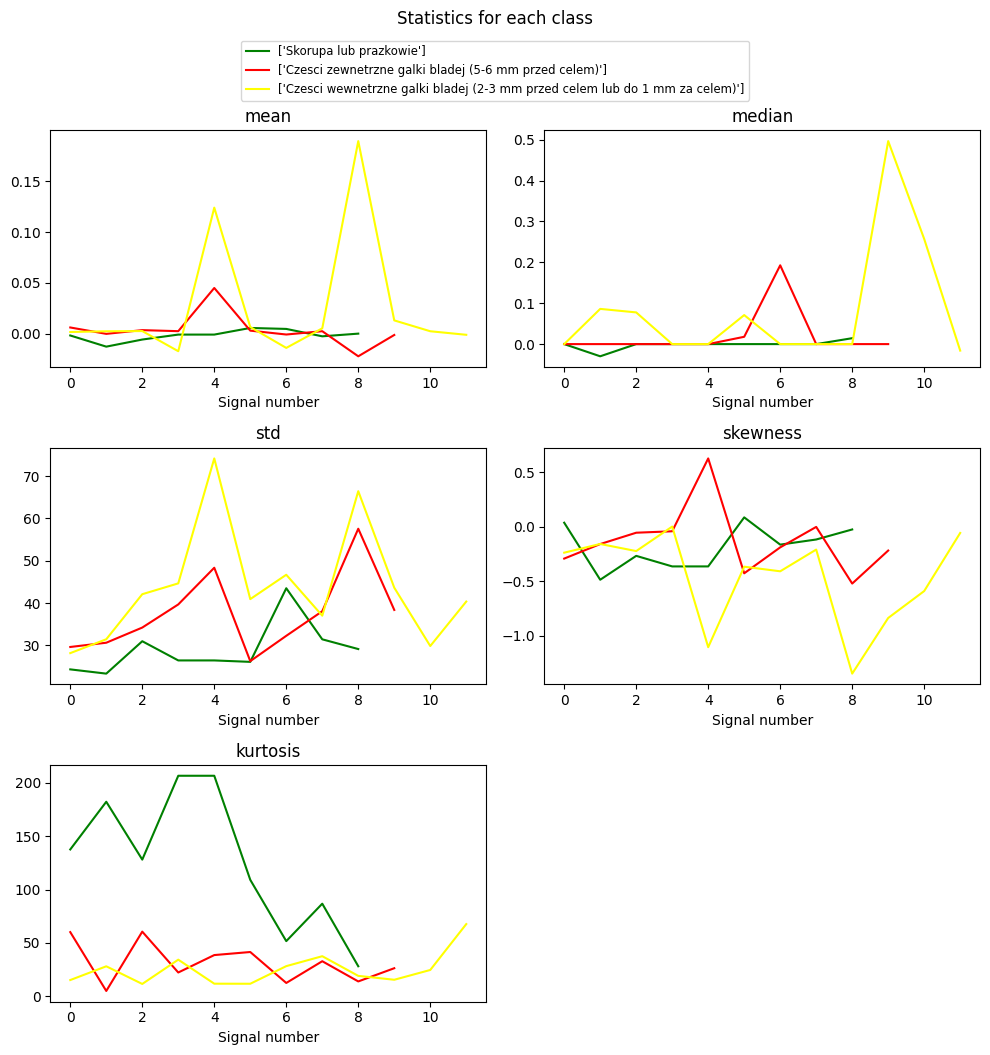

In [113]:
statistics_names = list(all_statistics.values())[0][0].keys()

# Create a new figure with subplots
number_of_plots = len(list(all_statistics.values())[0][0].keys())
number_of_columns = 2
number_of_rows = (number_of_plots+1)//number_of_columns
number_of_subplots = number_of_rows * number_of_columns
fig, axs = plt.subplots(number_of_rows, number_of_columns, figsize=(10, 10))

# Create an empty list to store the legend handles and labels
legend_handles = []

# Iterate over each statistic
for i, statistic in enumerate(statistics_names):
    # Calculate the row and column indices for the current subplot
    row = i // 2
    col = i % 2

    # Iterate over each label and plot the statistic on a subplot
    for label, statistics_list in all_statistics.items():
        # Get the values of the statistic for the current label
        values = [statistics[statistic] for statistics in statistics_list]

        color = 'gray'
        if label == "['Skorupa lub prazkowie']":
            color = 'green'
        if label == "['Czesci zewnetrzne galki bladej (5-6 mm przed celem)']":
            color = 'red'
        if label == "['Czesci wewnetrzne galki bladej (2-3 mm przed celem lub do 1 mm za celem)']":
            color = 'yellow'

        # Plot the values on the corresponding subplot and store the legend handle
        handle, = axs[row, col].plot(values, label=label, color=color)
        legend_handles.append(handle)

    # Set the title of the subplot to the statistic
    axs[row, col].set_title(statistic)

    # set the x-axis label
    axs[row, col].set_xlabel('Signal number')

# Add a single legend to the figure using the handles and labels
fig.legend(handles=legend_handles, labels=all_statistics.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.025), fontsize='small')

# Add titles to the figure
fig.suptitle('Statistics for each class', y=1.05)

# Remove the unused subplots
if number_of_plots < number_of_subplots:
    for i in range(number_of_plots, number_of_subplots):
        fig.delaxes(axs.flatten()[i])

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\Mateusz\AppData\Local\Temp\ipykernel_2972\2800412123.py:64: UserWarning: Mismatched number of handles and labels: len(handles) = 12 len(labels) = 3
  fig.legend(handles=legend_handles, labels=all_statistics.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.025), fontsize='small')


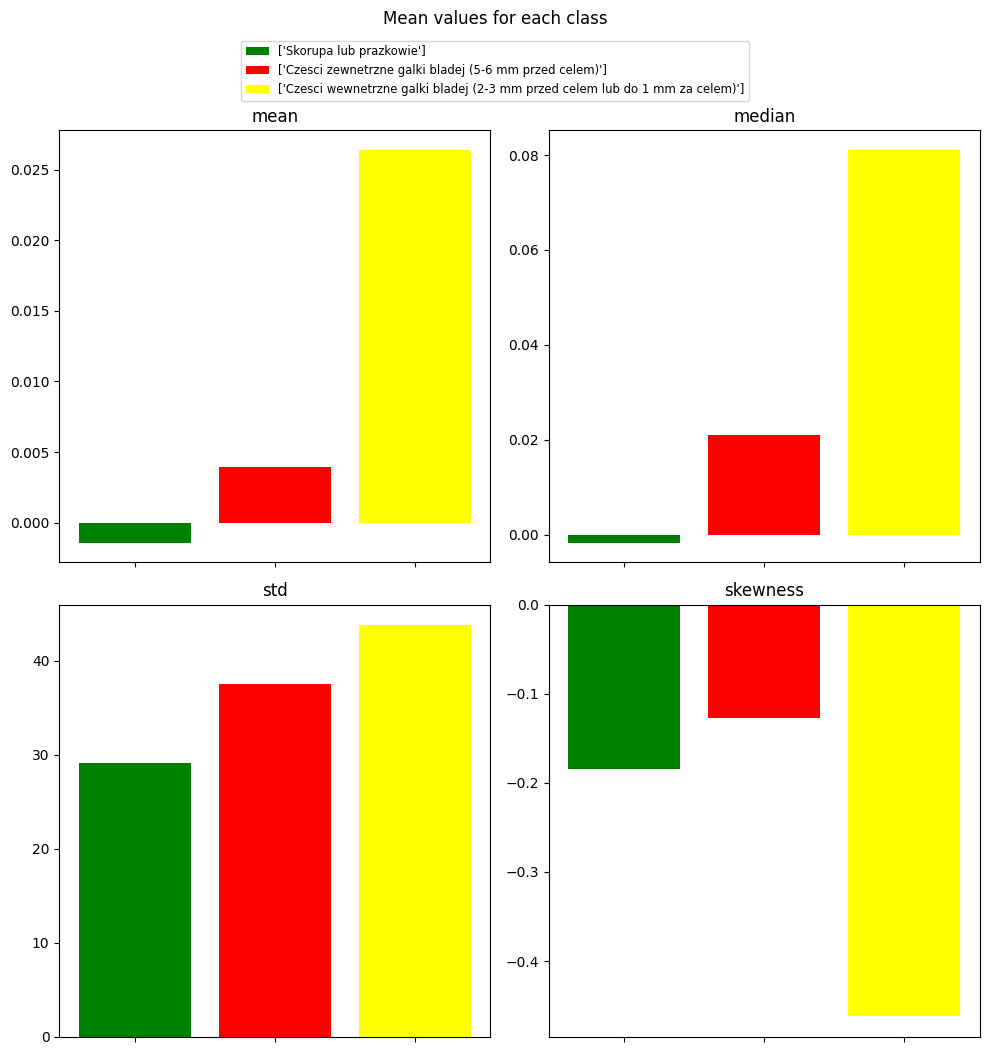

In [98]:
# Create a new figure with subplots
number_of_plots = len(list(all_statistics.values())[0][0].keys())
number_of_columns = 2
number_of_rows = (number_of_plots+1)//number_of_columns
number_of_subplots = number_of_rows * number_of_columns
fig, axs = plt.subplots(number_of_rows, number_of_columns, figsize=(10, 10))

# Create an empty list to store the legend handles and labels
legend_handles = []


# Calculate mean of each statistic per label
plot_values = {}

# Iterate over each label and plot the statistic on a subplot
for label, statistics_list in all_statistics.items():
    avg_dict = {}

    for statistics in statistics_list:
        for key, value in statistics.items():
            if key not in avg_dict:
                avg_dict[key] = []
            avg_dict[key].append(value)
        
    for key, value in avg_dict.items():
        avg_dict[key] = np.mean(value)

    plot_values[label] = avg_dict

# Iterate over each label and plot the statistic on a subplot
for i, statistic in enumerate(statistics_names):
    # Calculate the row and column indices for the current subplot
    row = i // 2
    col = i % 2

    # Iterate over each label and plot the statistic on a subplot
    for label, statistics in plot_values.items():
        # Get the values of the statistic for the current label
        value = statistics[statistic]

        color = 'gray'
        if label == "['Skorupa lub prazkowie']":
            color = 'green'
        if label == "['Czesci zewnetrzne galki bladej (5-6 mm przed celem)']":
            color = 'red'
        if label == "['Czesci wewnetrzne galki bladej (2-3 mm przed celem lub do 1 mm za celem)']":
            color = 'yellow'

        # Plot the values on the corresponding subplot and store the legend handle
        handle, = axs[row, col].bar(label, value, color=color, label=label)
        legend_handles.append(handle)

    # Disable the x-axis labels
    axs[row, col].set_xticklabels([])

    # Add title to the subplot
    axs[row, col].set_title(statistic)


# Set the title of the subplot to the statistic
axs[row, col].set_title(statistic)

# Add a single legend to the figure using the handles and labels
fig.legend(handles=legend_handles, labels=all_statistics.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.025), fontsize='small')

# Add titles to the figure
fig.suptitle('Mean values for each class', y=1.05)

# Remove the unused subplots
if number_of_plots < number_of_subplots:
    for i in range(number_of_plots, number_of_subplots):
        fig.delaxes(axs.flatten()[i])

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()
